In [1]:
import pandas as pd
import numpy as np
import pickle
from CPH_h import cph_KFold, plot_survival_curves_for_stage
from lifelines.statistics import proportional_hazard_test
from sksurv.metrics import brier_score, cumulative_dynamic_auc
from sksurv.util import Surv
import matplotlib.pyplot as plt

# Load Data Sources into Pandas Dataframes

In [2]:
# MIMIC-IV base data set
df_base = pd.read_pickle('../MIMIC_IV/df_ckd_base.pkl')
df_master = pd.read_pickle('../MIMIC_IV/df_ckd_master_clean.pkl')

# Initial View of the MIMIC-IV Base Dataset (Only KFRE Risk Factors)
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_id                        14012 non-null  int64  
 1   gender                            14012 non-null  int64  
 2   anchor_age                        14012 non-null  Int64  
 3   disch_age                         14012 non-null  int64  
 4   CKD_stage_first                   14012 non-null  float64
 5   first_stage_icd                   14012 non-null  int64  
 6   stage_delta                       14012 non-null  float64
 7   duration                          14012 non-null  int64  
 8   eGFR_first                        14012 non-null  float64
 9   eGFR_last                         14012 non-null  float64
 10  eGFR_min                          14012 non-null  float64
 11  eGFR_max                          14012 non-null  float64
 12  eGFR

# Join MIMIC-IV Base Dataset with Top 40 Features Identified By XGboost

In [3]:
# Load the list from the pickle file
with open('../XGboost/XGboost40.pkl', 'rb') as f:
    XGboost40 = pickle.load(f)

print(XGboost40)

['Creatinine_max', 'Renal dialysis status', 'Urea_Nitrogen_max', 'Creatinine_mean', 'Creatinine_median', 'Creatinine_last', 'Urea_Nitrogen_last', 'Potassium_max', 'Bilirubin,_Total_mean', 'Creatinine_min', 'Hemoglobin_min_y', 'Hemoglobin_max_y', 'Creatinine,_Urine_min', 'White_Blood_Cells_min', 'Unspecified essential hypertension', 'Neutrophils_min', 'Sodium_min', 'Protein/Creatinine_Ratio_mean', 'Congestive heart failure, unspecified', 'Uric_Acid_min', 'Neutrophils_max', 'MCHC_min', 'White_Blood_Cells_last', 'Neutrophils_last', 'Orthostatic hypotension', 'Urea_Nitrogen_mean', 'Platelet_Count_min', 'Protein,_Total_last', 'Basophils_mean', 'MCV_last', 'Protein,_Total_max', 'Urea_Nitrogen_median', 'Cholesterol,_LDL,_Calculated_max', 'Total_Protein,_Urine_max', 'Monocytes_mean', 'hadm_id_first_CKD', 'Platelet_Count_last', 'MCH_min', 'Hemoglobin_last_y', 'Bilirubin,_Total_max']


In [4]:
# Select these columns from df_source
XGboost40 = ['subject_id'] + XGboost40
df_XGboost40 = df_master[XGboost40]

df_plusXGboost = pd.merge(df_base, df_XGboost40, on='subject_id', how='outer')

df_plusXGboost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Data columns (total 84 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             14012 non-null  int64  
 1   gender                                 14012 non-null  int64  
 2   anchor_age                             14012 non-null  Int64  
 3   disch_age                              14012 non-null  int64  
 4   CKD_stage_first                        14012 non-null  float64
 5   first_stage_icd                        14012 non-null  int64  
 6   stage_delta                            14012 non-null  float64
 7   duration                               14012 non-null  int64  
 8   eGFR_first                             14012 non-null  float64
 9   eGFR_last                              14012 non-null  float64
 10  eGFR_min                               14012 non-null  float64
 11  eG

# Fit Cox Proportional Hazards Model with Top 40 XGboost Features

In [5]:
# Drop unecessary columns
df_plusXGboost.drop('first_stage_icd', axis=1, inplace=True)

# Five-fold cross validation to fit model
best_c_index, avg_c_index, cph, train, test = cph_KFold(df_plusXGboost, n_splits=5, penalizer=0.0007)

# Output the average C-index from cross validation
print(f'Average C-Index from cross-validation: {avg_c_index:.4f}')

# Output the best C-index and the corresponding train/test split indices
print(f'Best C-Index from cross-validation: {best_c_index:.4f}')

Iteration 1: norm_delta = 6.50e+00, step_size = 0.9500, log_lik = -8744.90665, newton_decrement = 9.96e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 5.22e+00, step_size = 0.2375, log_lik = -8329.31163, newton_decrement = 5.57e+02, seconds_since_start = 0.2
Iteration 3: norm_delta = 4.89e+00, step_size = 0.0772, log_lik = -8246.56938, newton_decrement = 4.80e+02, seconds_since_start = 0.3
Iteration 4: norm_delta = 4.35e+00, step_size = 0.1304, log_lik = -8129.34530, newton_decrement = 3.72e+02, seconds_since_start = 0.3
Iteration 5: norm_delta = 3.52e+00, step_size = 0.2205, log_lik = -7983.20565, newton_decrement = 2.36e+02, seconds_since_start = 0.4
Iteration 6: norm_delta = 2.33e+00, step_size = 0.3726, log_lik = -7839.59975, newton_decrement = 9.95e+01, seconds_since_start = 0.5
Iteration 7: norm_delta = 9.30e-01, step_size = 0.6296, log_lik = -7753.17127, newton_decrement = 1.53e+01, seconds_since_start = 0.6
Iteration 8: norm_delta = 1.42e-02, step_size = 1.0000, log_li

In [6]:
cph_summary = cph.summary

# Save the summary to a CSV file
cph_summary.to_csv('XGboostSummary.csv', index=True)

# Print the model summary
display(cph_summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
subject_id,-1.572349e-08,1.000000,1.015266e-08,-3.562235e-08,4.175362e-09,1.000000,1.000000,0.0,-1.548706,1.214524e-01,3.041537
gender,1.061362e-01,1.111973,6.940139e-02,-2.988802e-02,2.421604e-01,0.970554,1.273999,0.0,1.529309,1.261878e-01,2.986356
anchor_age,3.544080e-01,1.425337,1.475453e-02,3.254896e-01,3.833263e-01,1.384708,1.467157,0.0,24.020279,1.707421e-127,421.113050
disch_age,-3.574630e-01,0.699449,1.470410e-02,-3.862825e-01,-3.286435e-01,0.679579,0.719900,0.0,-24.310434,1.520566e-130,431.246044
CKD_stage_first,-1.085063e+00,0.337881,4.816098e-02,-1.179457e+00,-9.906690e-01,0.307446,0.371328,0.0,-22.529916,2.113543e-112,370.976283
...,...,...,...,...,...,...,...,...,...,...,...
hadm_id_first_CKD,-7.626800e-09,1.000000,1.025365e-08,-2.772358e-08,1.246998e-08,1.000000,1.000000,0.0,-0.743813,4.569894e-01,1.129767
Platelet_Count_last,-1.772138e-04,0.999823,3.602587e-04,-8.833078e-04,5.288802e-04,0.999117,1.000529,0.0,-0.491907,6.227851e-01,0.683194
MCH_min,6.711545e-02,1.069419,1.896317e-02,2.994831e-02,1.042826e-01,1.030401,1.109914,0.0,3.539252,4.012626e-04,11.283166


# Examine Feature Importances

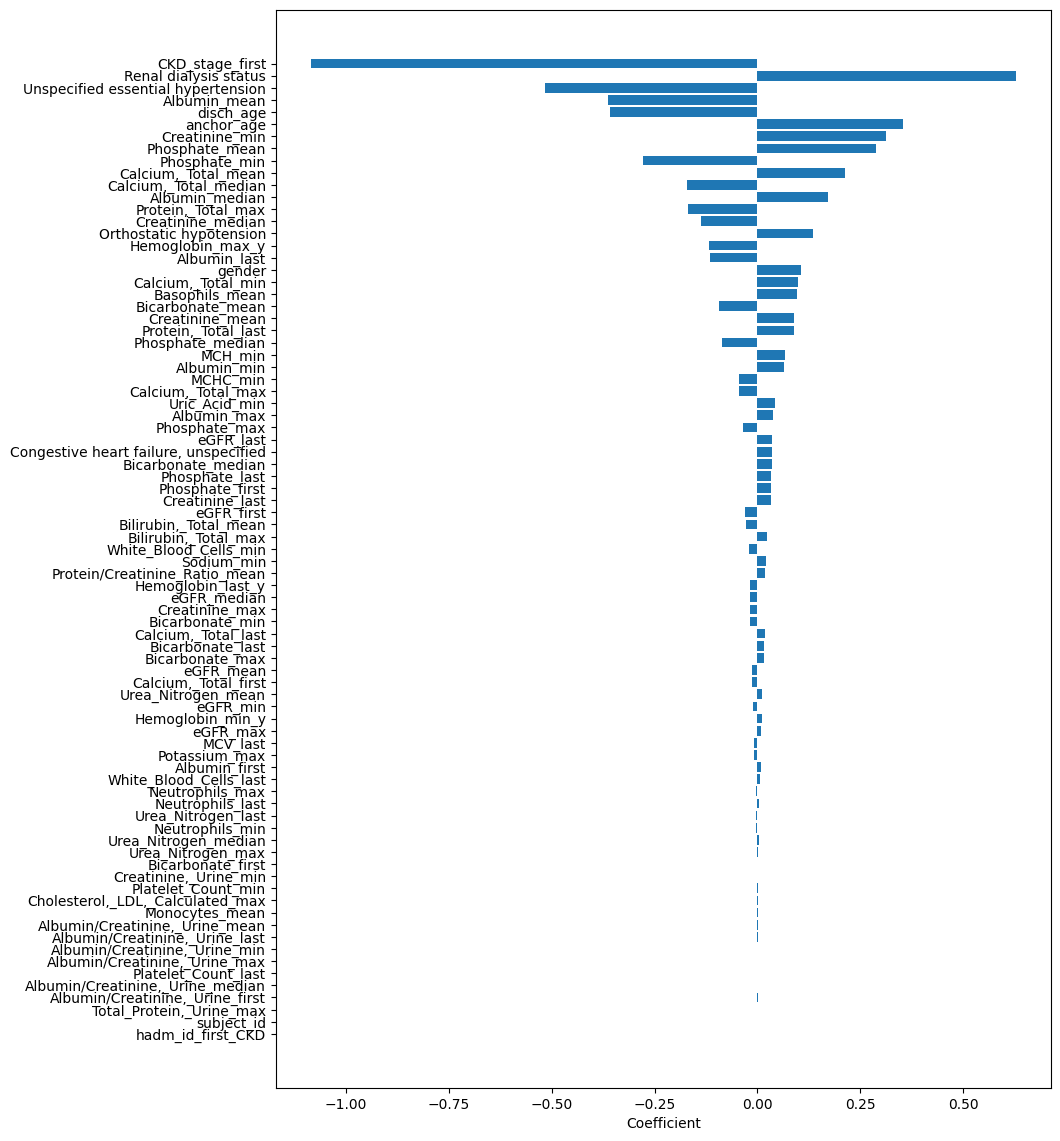

In [7]:
# Extract the coefficients and their corresponding feature names
coefficients = cph.params_
feature_importances = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
})

# Sort the features by the absolute value of the coefficients
feature_importances['Abs_Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 14))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'])
plt.xlabel('Coefficient')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Save the plot as a PNG file
plt.savefig("figs/XGboostFeatures.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Schoenfeld Test

In [8]:
# Perform Schoenfeld test to assess the proportional hazards assumption
results = proportional_hazard_test(cph, train, time_transform='rank')
results_summary = results.summary

# Save the results summary to a CSV file
results_summary.to_csv('XGboostSchoenfeld.csv', index=True)

display(results_summary)

,test_statistic,p,-log2(p)
"Albumin/Creatinine,_Urine_first",0.132669,0.715681,0.482612
"Albumin/Creatinine,_Urine_last",0.010905,0.916830,0.125274
"Albumin/Creatinine,_Urine_max",0.221043,0.638246,0.647815
"Albumin/Creatinine,_Urine_mean",0.470561,0.492729,1.021133
"Albumin/Creatinine,_Urine_median",1.089406,0.296603,1.753396
...,...,...,...
eGFR_median,0.029513,0.863599,0.211567
eGFR_min,0.036199,0.849106,0.235983
gender,0.823827,0.364064,1.457737
hadm_id_first_CKD,0.575671,0.448014,1.158384


# Brier Score Plot

In [9]:
# Prepare the survival data in the format required by scikit-survival
survival_train = Surv.from_dataframe('stage_delta', 'duration', train)
survival_test = Surv.from_dataframe('stage_delta', 'duration', test)

# Prepare the feature data
X_train = train.drop(columns=['duration', 'stage_delta'])
X_test = test.drop(columns=['duration', 'stage_delta'])

# Predict the survival function for the test data using the fitted model
survival_functions = cph.predict_survival_function(X_test)

# Extract available times directly from the survival functions
available_times = survival_functions.index

# Ensure valid_times are strictly within the follow-up time range of the test data
test_duration_min, test_duration_max = test['duration'].min(), test['duration'].max()
valid_times = available_times[(available_times > test_duration_min) & (available_times < test_duration_max)]

# Extract survival probabilities at the specified time points
estimate = survival_functions.loc[valid_times].T.values

# Calculate Brier scores using scikit-survival
valid_times, brier_scores = brier_score(
    survival_train=survival_train,
    survival_test=survival_test,
    estimate=estimate,
    times=valid_times
)

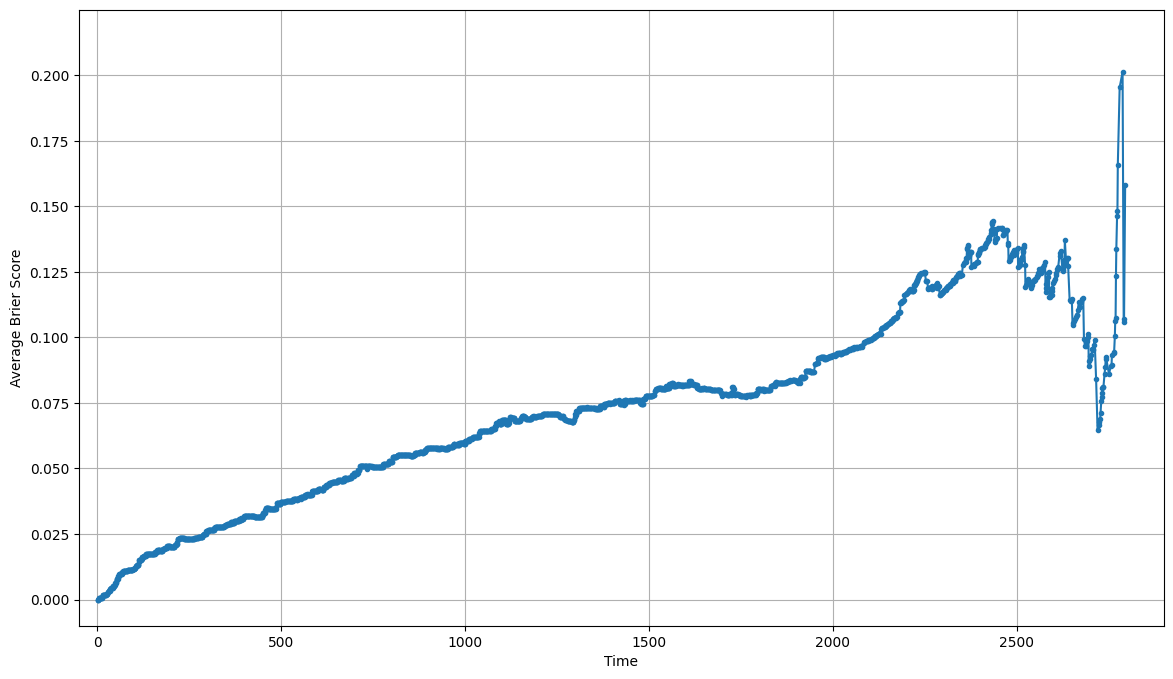

In [10]:
# Create a plot of Brier scores over time
plt.figure(figsize=(14, 8))
plt.plot(valid_times, brier_scores, marker='o', markersize=3)  # Adjust markersize here
plt.xlabel('Time')
plt.ylabel('Average Brier Score')
plt.yticks(np.arange(0, 0.225, 0.025))
plt.grid(True)
plt.xlim(-50, 2900)
plt.ylim(-0.01, 0.225)

# Save the plot as a PNG file
plt.savefig("figs/XGboostBrier.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Time-Dependent ROC Curves

In [11]:
# Predict risk scores for the test data using the fitted model
risk_scores = cph.predict_partial_hazard(X_test)

# Define time points to evaluate ROC curves
times = np.arange(1, test['duration'].max() + 1, 1)

# Ensure times are within the follow-up time range of the test data
valid_times = times[(times >= test['duration'].min()) & (times < test['duration'].max())]

# Compute time-dependent ROC curves using valid times
auc_values, mean_auc = cumulative_dynamic_auc(survival_train, survival_test, risk_scores, valid_times)

C:\Users\zdana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sksurv\metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


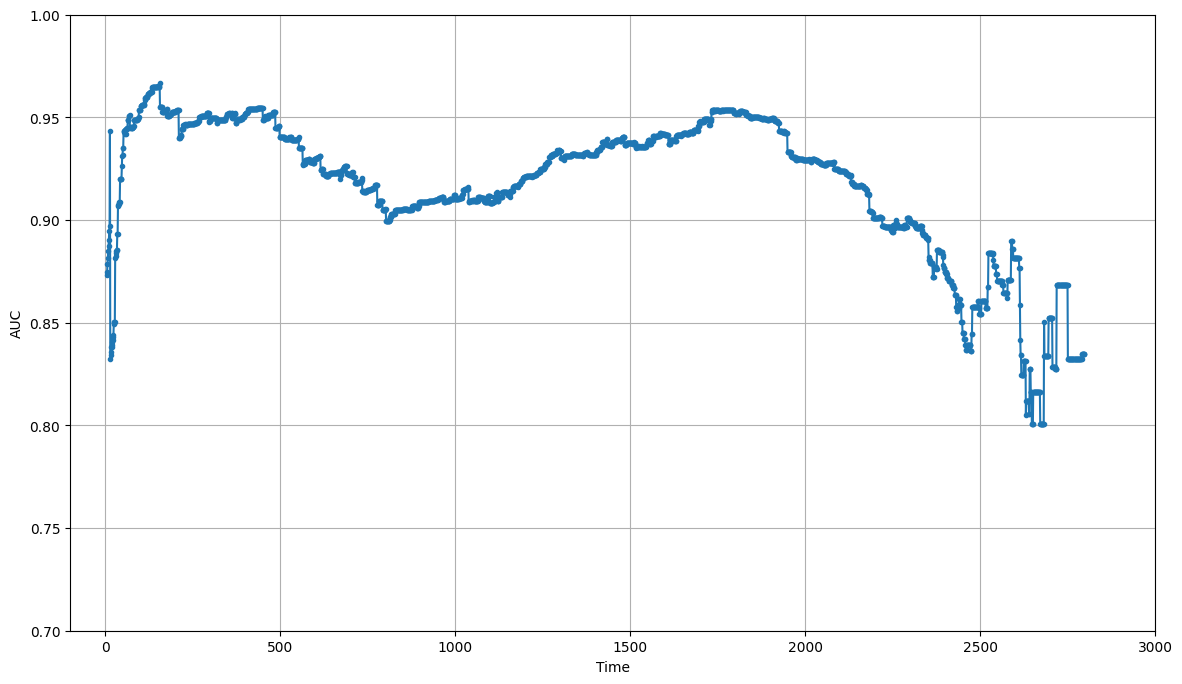

In [12]:
# Plot mean AUC over time
plt.figure(figsize=(14, 8))
plt.plot(valid_times, auc_values, marker='o', markersize=3)
plt.xlabel('Time')
plt.ylabel('AUC')
plt.grid(True)
plt.xlim(-100, 3000)
plt.ylim(0.70, 1.0)

# Save the plot as a PNG file
plt.savefig("figs/XGboostTimeDepAUC.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Visualize the Survival Functions by CKD Stage

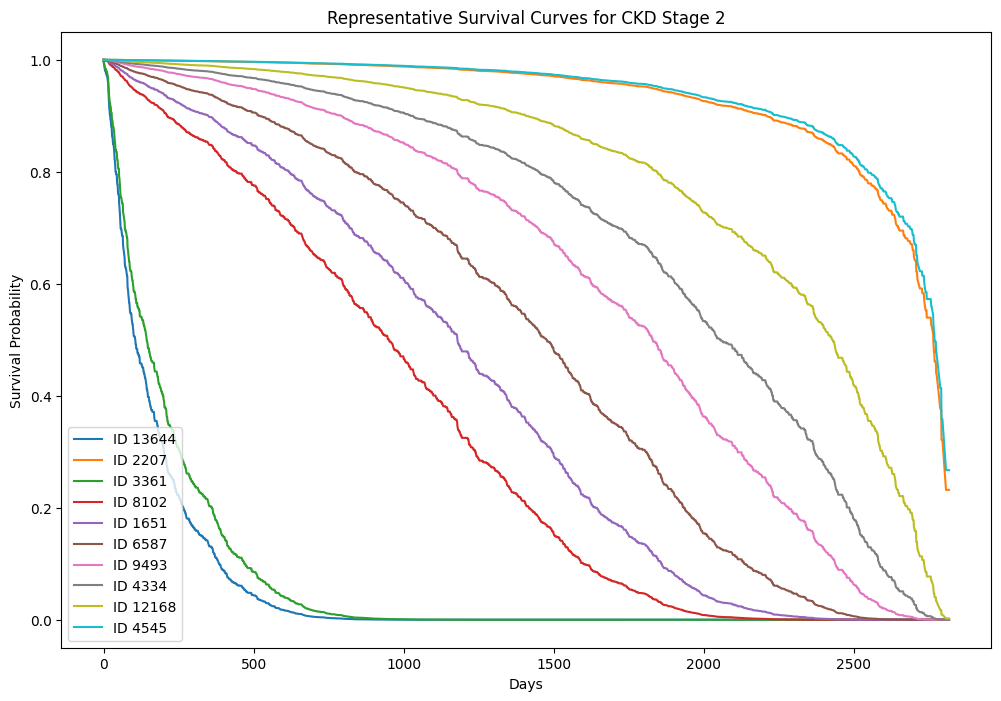

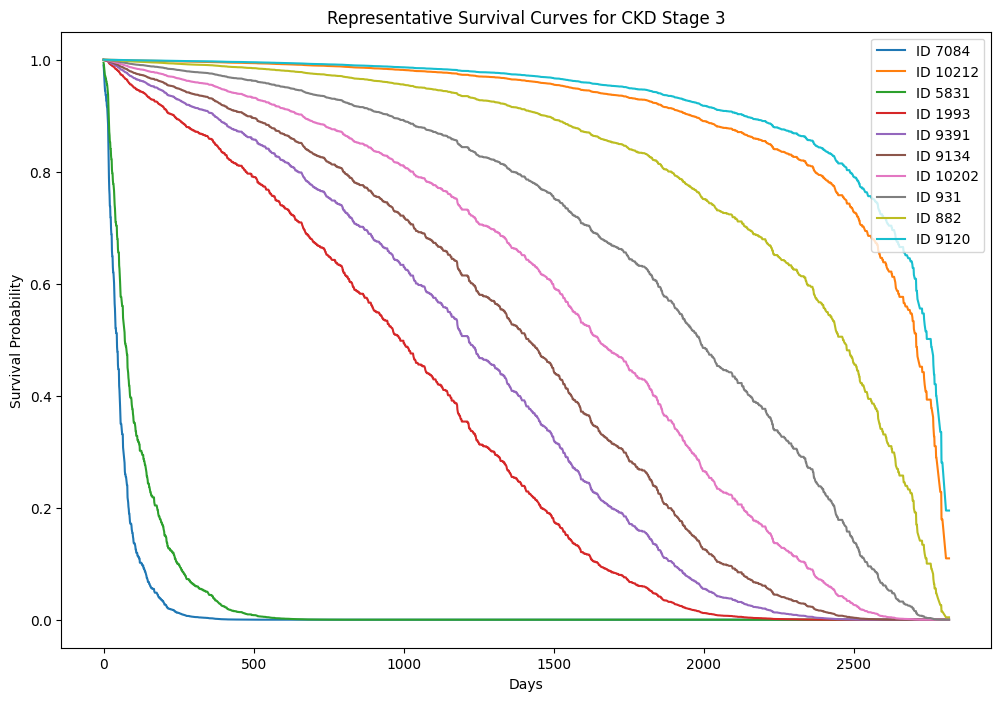

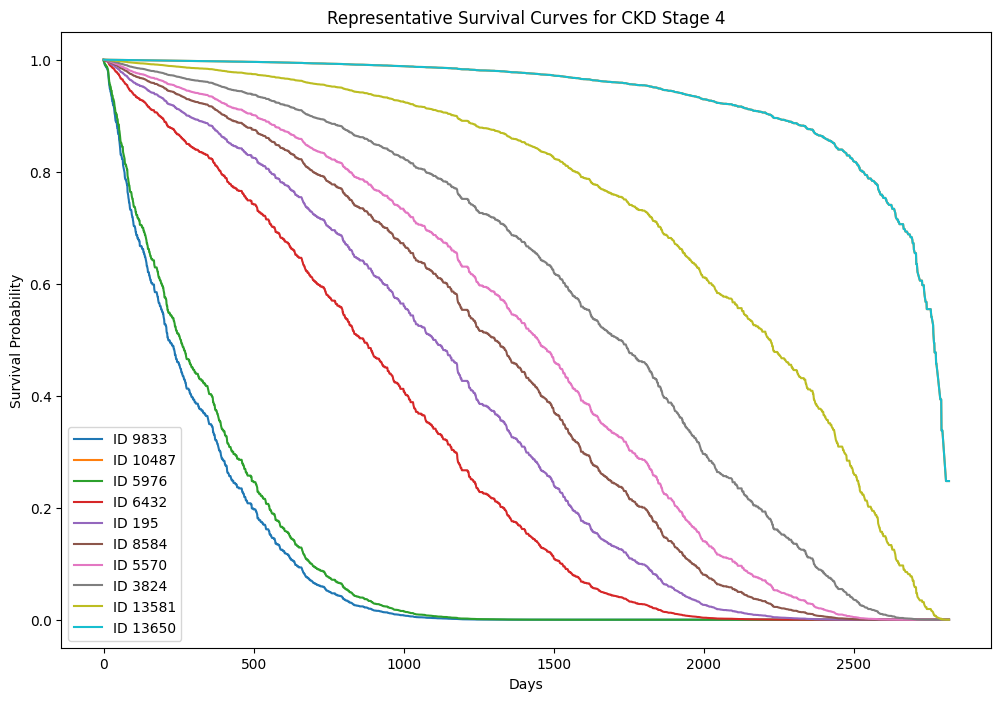

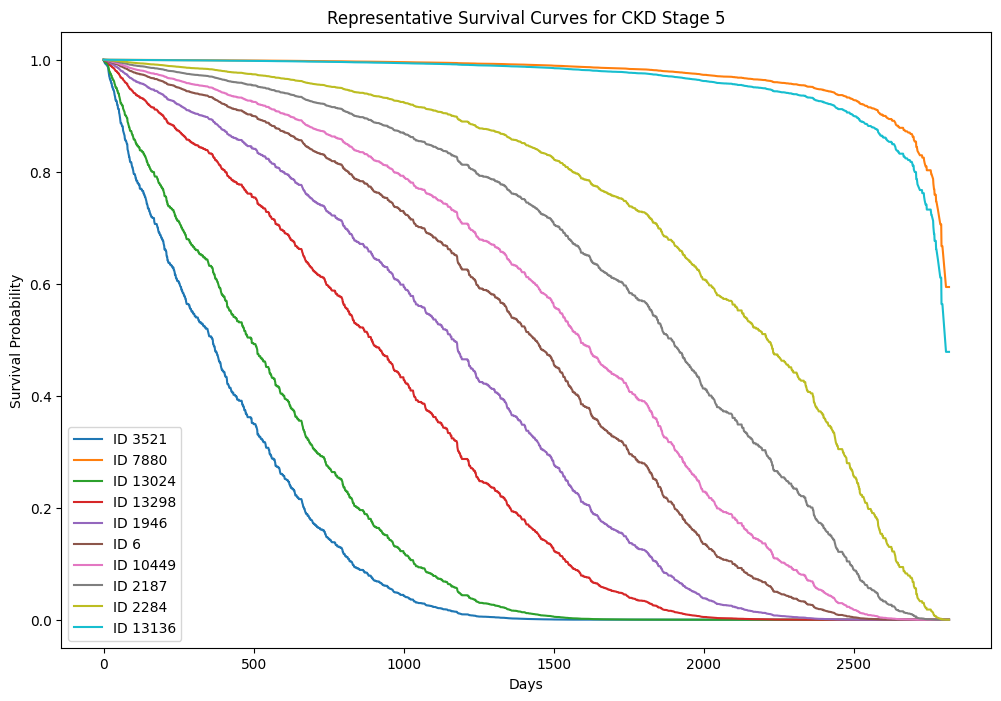

In [13]:
# Iterate through CKD stages 1 to 5 and plot the survival curves for each stage
for stage in range(2, 6):
    plot_survival_curves_for_stage(stage, 'XGboost', test, cph)